**Class 4: Temporal difference policy optimization.**



In previous classes, we saw how value functions can be learned from samples. We now turn to the problem of learning the optimal value function for a given MDP. Model-based policy optimization provided us with the value and policy iteration methods. We investigate how we can learn their solutions via sampling and stochastic approximation to replace the knowledge of a model.

<div class="alert alert-warning">

**Prerequisites:**
- Stochastic Approximation / Stochastic Gradient Descent
- MDPs, policies, value functions, stationary distribution
- Value Iteration, Policy Iteration
<div>

# Everything you need to know

# Reminder

- Value Iteration
- Policy Iteration
- TD(0)

# Approximate Policy Iteration as Stochastic Approximation

## Approximate Policy Iteration based on TD(0)

In the previous classes, we have seen that we could learn a policy's $Q$ function with temporal differences, yielding the TD(0) method.

But we also have seen that given a policy's (approximate) $Q$ function, we can define the greedy policy $\mathcal{G}(Q)$ with respect to $Q$. Repeating this evaluation and improvement process provided the (approximate) policy iteration algorithm that lead to (a neighborhood of) an optimal policy.

So let's start with this.  
<div class="alert alert-warning">

**Exercice**  
Write a model-free approximate policy iteration algorithm that uses TD(0) on $Q$ functions with random behavior policy, as a method to obtain a policy $\pi_n$'s approximate value function $Q_n$. Take $\pi_{n+1} = \mathcal{G}(Q)$ every $N=1000$ steps of TD(0).  
Test this algorithm on FrozenLake with $\gamma=0.9$, $\alpha=0.001$ and for $2000000$ time steps.  
Use a model-based policy evaluation function and a value iteration algorithm from previous classes to compute $Q^*$ and monitor the difference between $Q^\pi$ and $Q^*$ after each policy update.  
As an initial guess, initialize $Q$ to zero and take the greedy policy.  
Don't hesitate to (massively) re-use solutions from past classes' exercices.
</div>

←↑→↑
←←←←
↑↓←←
←→↓←
[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]


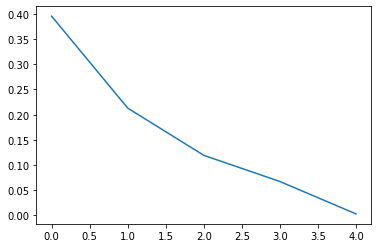

In [7]:
# %load solutions/RL4_exercice1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

def greedyQpolicy(Q):
    pi = np.zeros((env.observation_space.n),dtype=np.int)
    for s in range(env.observation_space.n):
        pi[s] = np.argmax(Q[s,:])
    return pi

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def print_policy(pi):
    actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}
    for row in range(env.unwrapped.nrow):
        for col in range(env.unwrapped.ncol):
            print(actions[pi[to_s(row,col)]], end='')
        print()
    return

def value_iteration(V,epsilon,max_iter):
    W = np.copy(V)
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for s in range(env.observation_space.n):
            Q = np.zeros((env.action_space.n))
            for a in range(env.action_space.n):
                outcomes = env.unwrapped.P[s][a]
                for o in outcomes:
                    p  = o[0]
                    s2 = o[1]
                    r  = o[2]
                    Q[a] += p*(r+gamma*V[s2])
            W[s] = np.max(Q)
            #print(W[s])
        residuals[i] = np.max(np.abs(W-V))
        #print("abs", np.abs(W-V))
        np.copyto(V,W)
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

def Q_from_V(V):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[s][a]
            for o in outcomes:
                p  = o[0]
                s2 = o[1]
                r  = o[2]
                Q[s,a] += p*(r+gamma*V[s2])
    return Q

def policy_eval_iter_mat(pi, max_iter):
    # build r and P
    r_pi = np.zeros((env.observation_space.n))
    P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
    for x in range(env.observation_space.n):
        outcomes = env.unwrapped.P[x][pi[x]]
        for o in outcomes:
            p = o[0]
            y = o[1]
            r = o[2]
            P_pi[x,y] += p
            r_pi[x] += r*p
    # Compute V
    V = np.zeros((env.observation_space.n))
    for i in range(max_iter):
        V = r_pi + gamma * np.dot(P_pi, V)
    return V

# Policy definition and parameters
Q0  = np.zeros((env.observation_space.n,env.action_space.n))
gamma = 0.9
alpha = 0.001
max_steps=2000000
update_period=500000
optimality_gap = []

# Model-based optimisation
Vinit = np.zeros((env.observation_space.n))
Vstar,residuals = value_iteration(Vinit,1e-4,1000)
Qstar = Q_from_V(Vstar)

Q = np.copy(Q0)
x = env.reset()
for t in range(max_steps):
    # update policy every N steps
    if t%update_period==0:
        pi = greedyQpolicy(Q)
        # evaluate policy (just for monitoring)
        Qpi = Q_from_V(policy_eval_iter_mat(pi, 1000))
        optimality_gap.append(np.max(np.abs(Qpi-Qstar)))
    # random behavior policy
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    # TD(0) update
    Q[x][a] = Q[x][a] + alpha * (r+gamma*Q[y][pi[y]]-Q[x][a])
    if d==True:
        x = env.reset()
    else:
        x=y

pi = greedyQpolicy(Q)
Qpi = Q_from_V(policy_eval_iter_mat(pi, 1000))
optimality_gap.append(np.max(np.abs(Qpi-Qstar)))
print_policy(pi)
print(pi-greedyQpolicy(Qstar)) # remember there may be several optimal policies
plt.plot(optimality_gap);

In [8]:
np.min(optimality_gap)

0.002995067462725126

<div class="alert alert-danger"><a href="#PI-TD0-1000" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="PI-TD0-1000" class="collapse">
    
This is the type of graph you should obtain:
<img src="img/PI-TD0-1000.png" style="height: 200px;"></img>

As is often the case with Policy Iteration, the policy's value quickly reaches a good neighborhood of $Q^*$. But then it tends to oscillate due to the policy approximation.
    
</div>
</div>

## Interleaving policy improvement and evaluation

Now let's bring the update frequency of the policy down to 1.  
At any given time, the algorithm has a current value function $Q$ and policy $\pi$. Taking $N=1$ amounts to approximating $Q^{\pi}$ by taking a single stochastic approximation step from $Q$ towards $T^{\pi} Q$. So, after collecting sample $(s,a,r,s')$:
$$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma Q(s',\pi(s'))-  Q(s,a) ).$$

Then, $\pi$ is immediately redefined as $\mathcal{G}(Q)$.

<div class="alert alert-warning">

**Exercice:**  
Modify your code above to experiment with $N=1$.  
To keep reasonable running times, only evaluate the policy every $1000$ updates.
</div>

←↑←↑
←←←←
↑↓←←
←→↓←
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


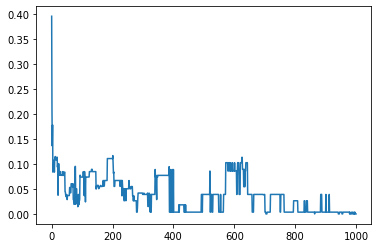

In [4]:
# %load solutions/RL4_exercice2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import gym
import gym.envs.toy_text.frozen_lake as fl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')

def greedyQpolicy(Q):
    pi = np.zeros((env.observation_space.n),dtype=np.int)
    for s in range(env.observation_space.n):
        pi[s] = np.argmax(Q[s,:])
    return pi

def to_s(row,col):
    return row*env.unwrapped.ncol+col

def print_policy(pi):
    actions = {fl.LEFT: '\u2190', fl.DOWN: '\u2193', fl.RIGHT: '\u2192', fl.UP: '\u2191'}
    for row in range(env.unwrapped.nrow):
        for col in range(env.unwrapped.ncol):
            print(actions[pi[to_s(row,col)]], end='')
        print()
    return

def value_iteration(V,epsilon,max_iter):
    W = np.copy(V)
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for s in range(env.observation_space.n):
            Q = np.zeros((env.action_space.n))
            for a in range(env.action_space.n):
                outcomes = env.unwrapped.P[s][a]
                for o in outcomes:
                    p  = o[0]
                    s2 = o[1]
                    r  = o[2]
                    Q[a] += p*(r+gamma*V[s2])
            W[s] = np.max(Q)
            #print(W[s])
        residuals[i] = np.max(np.abs(W-V))
        #print("abs", np.abs(W-V))
        np.copyto(V,W)
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

def Q_from_V(V):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[s][a]
            for o in outcomes:
                p  = o[0]
                s2 = o[1]
                r  = o[2]
                Q[s,a] += p*(r+gamma*V[s2])
    return Q

def policy_eval_iter_mat(pi, max_iter):
    # build r and P
    r_pi = np.zeros((env.observation_space.n))
    P_pi = np.zeros((env.observation_space.n, env.observation_space.n))
    for x in range(env.observation_space.n):
        outcomes = env.unwrapped.P[x][pi[x]]
        for o in outcomes:
            p = o[0]
            y = o[1]
            r = o[2]
            P_pi[x,y] += p
            r_pi[x] += r*p
    # Compute V
    V = np.zeros((env.observation_space.n))
    for i in range(max_iter):
        V = r_pi + gamma * np.dot(P_pi, V)
    return V

# Policy definition and parameters
Q0  = np.zeros((env.observation_space.n,env.action_space.n))
gamma = 0.9
alpha = 0.001
max_steps=1000000
update_period=1
eval_period=1000
optimality_gap = []

# Model-based optimisation
Vinit = np.zeros((env.observation_space.n))
Vstar,residuals = value_iteration(Vinit,1e-4,1000)
Qstar = Q_from_V(Vstar)

Q = np.copy(Q0)
x = env.reset()
for t in range(max_steps):
    # update policy every N steps
    if t%update_period==0:
        pi = greedyQpolicy(Q)
    # evaluate policy (just for monitoring)
    if t%eval_period==0:
        Qpi = Q_from_V(policy_eval_iter_mat(pi, 1000))
        optimality_gap.append(np.max(np.abs(Qpi-Qstar)))
    # random behavior policy
    a = np.random.randint(4)
    y,r,d,_ = env.step(a)
    # TD(0) update
    Q[x][a] = Q[x][a] + alpha * (r+gamma*Q[y][pi[y]]-Q[x][a])
    if d==True:
        x = env.reset()
    else:
        x=y

pi = greedyQpolicy(Q)
Qpi = Q_from_V(policy_eval_iter_mat(pi, 1000))
optimality_gap.append(np.max(np.abs(Qpi-Qstar)))
print_policy(pi)
print(pi-greedyQpolicy(Qstar)) # remember there may be several optimal policies
plt.plot(optimality_gap);

<div class="alert alert-danger"><a href="#PI-TD0-1" data-toggle="collapse"><b>Answer:</b></a><br>
<div id="PI-TD0-1" class="collapse">
    
This is the type of graph you should obtain:
<img src="img/PI-TD0-1.png" style="height: 200px;"></img>

The method still provides a policy that is close to optimal.
    
</div>
</div>

From the exercises above, one can see that a reasonably good policy can be found early, but that sometimes the policy oscillates around $\pi^*$ with sub-optimal policies.

If one has a replay memory of samples, it is possible to take a minibatch of these samples and:
$$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma Q(s',\pi(s'))-  Q(s,a) ).$$


# Approximate Value Iteration as Stochastic Approximation

The previous section built directly from the available TD(0) algorithm to build the policy iteration sequence of value functions and policies. But we know there is an another way to obtain $Q^*$, through value iteration.

# The three key challenges of Reinforcement Learning

- the exploration/exploitation trade-off
- value function approximation
- solving the maximization problem